<a href="https://colab.research.google.com/github/myschl/ML-DL/blob/master/PneumoNet_Best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Important Libraries that will be use**

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from tensorflow.keras import layers, models
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.utils import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import keras
import cv2
from keras import backend as K



# **Getting the Data From my Kaggle Account**

In [0]:
!pip install kaggle

In [25]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ludbaabdul","key":"af976bd2cc99621a6f0f50c5f5ba4ed8"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [27]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 14.8MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.7MB/s]


In [28]:
from zipfile import ZipFile
file_name = 'chest-xray-pneumonia.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


# **Data Augmentation sample in one image**

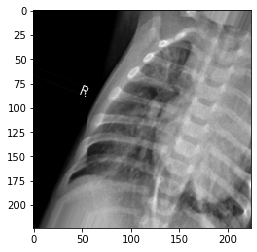

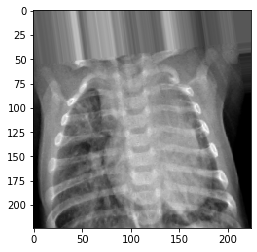

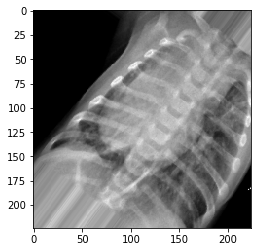

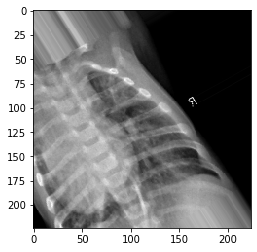

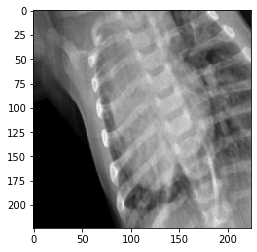

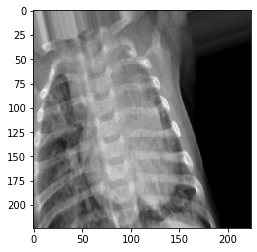

In [0]:
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,)


img_path = '/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 6 == 0:
    break
plt.show()

# **Data preferation**

**Preferring the test Data**

In [0]:
# Define path to the data directory
data_dir = Path('/content/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


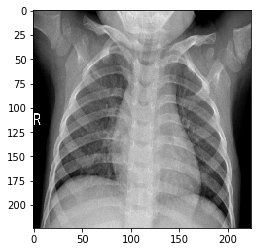

In [66]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    # label = 0
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    # label = 1
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print(test_labels)
print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)
plt.imshow(test_data[4])


In [40]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data

,image,label
0,/content/chest_xray/train/NORMAL/IM-0718-0001....,0
1,/content/chest_xray/train/NORMAL/NORMAL2-IM-05...,0
2,/content/chest_xray/train/PNEUMONIA/person872_...,1
3,/content/chest_xray/train/PNEUMONIA/person274_...,1
4,/content/chest_xray/train/NORMAL/IM-0631-0001-...,0
...,...,...
5211,/content/chest_xray/train/PNEUMONIA/person413_...,1
5212,/content/chest_xray/train/PNEUMONIA/person472_...,1
5213,/content/chest_xray/train/PNEUMONIA/person319_...,1
5214,/content/chest_xray/train/PNEUMONIA/person1241...,1


**Plotting the number of Pneumonia and Normal class in the Dataset**

1    3875
0    1341
Name: label, dtype: int64


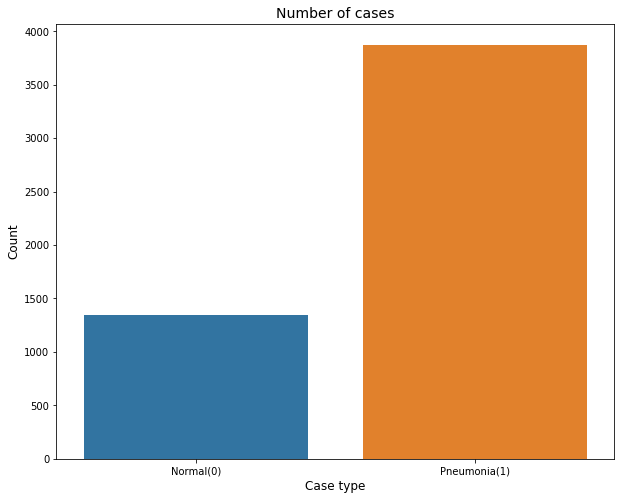

In [41]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

**Visualizing sample of training data images**

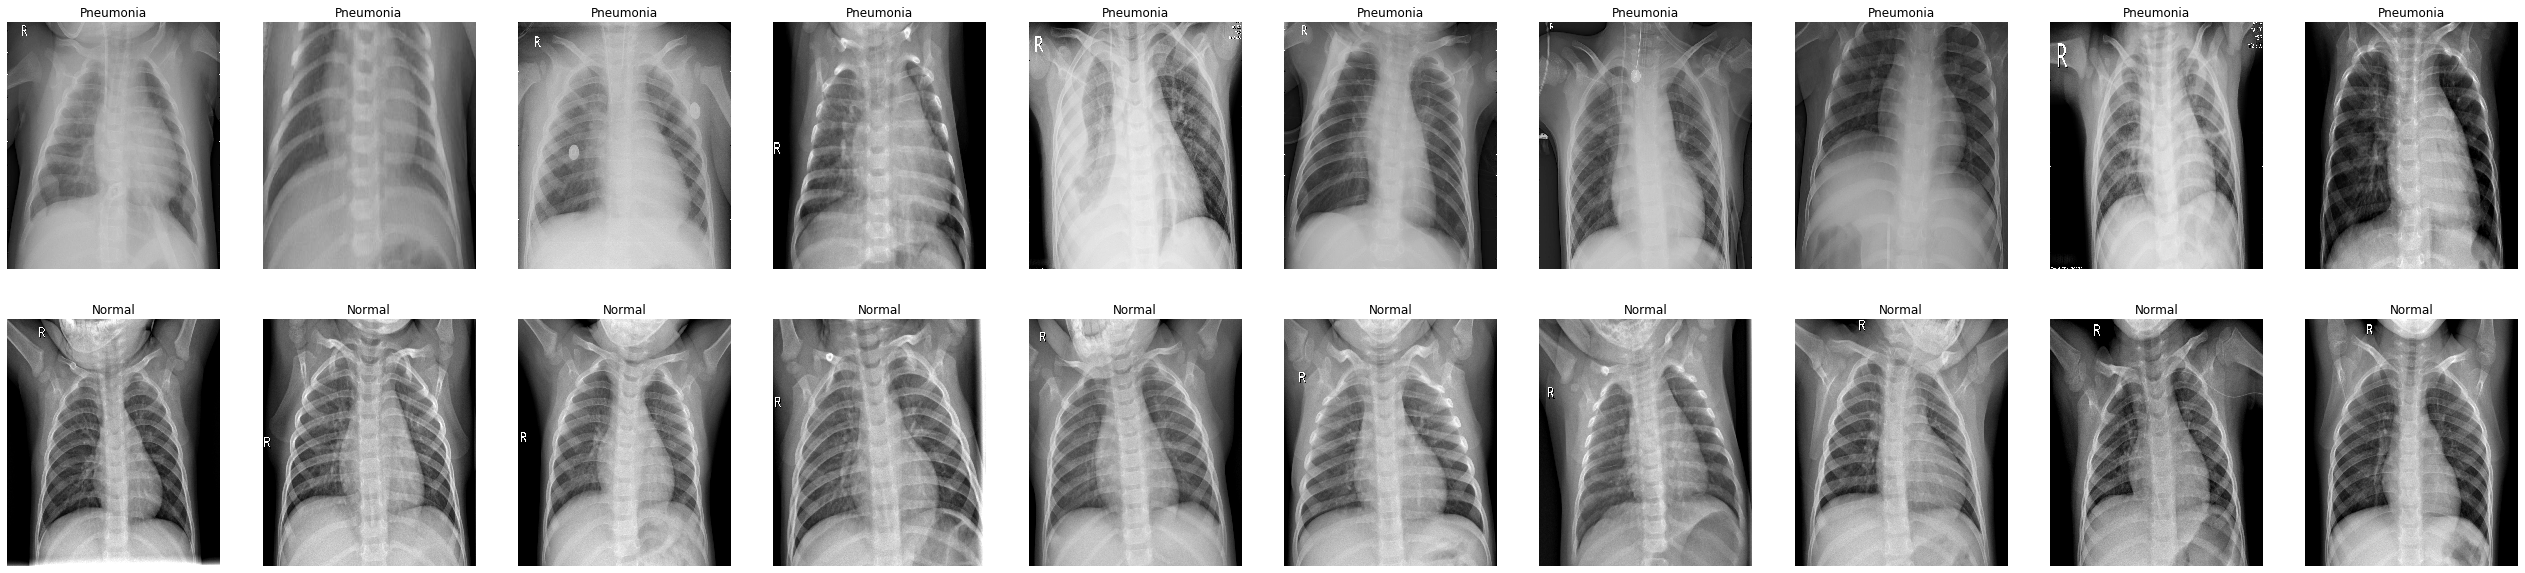

In [42]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:10]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:10]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,10, figsize=(45,10))
for i in range(20):
    img = imread(samples[i])
    ax[i//10, i%10].imshow(img, cmap='gray')
    if i<10:
        ax[i//10, i%10].set_title("Pneumonia")
    else:
        ax[i//10, i%10].set_title("Normal")
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_aspect('auto')
plt.show()

**Preferring train Data**

In [43]:
# Get the path to the sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain training images data and the corresponding labels
train_data = []
train_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    # label = to_categorical(0, num_classes=2)
    label = 0
    train_data.append(img)
    train_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    # label = to_categorical(1, num_classes=2)
    label = 1
    train_data.append(img)
    train_labels.append(label)
    
# Convert the list into numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

print("Total number of validation examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

Total number of validation examples:  (5216, 224, 224, 3)
Total number of labels: (5216,)


**Preferring Validation Data**

In [44]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    # label = to_categorical(0, num_classes=2)
    label = 0
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    # label = to_categorical(1, num_classes=2)
    label = 1
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16,)


# **Creating Model from scrach Architecture**

In [0]:
def get_model():
  from keras import optimizers
  from keras.optimizers import adam

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
  input_shape=(224, 224, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))

  # opt = adam(lr=0.001, decay=1e-6)
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

# **Visualizing Intermidiate Activation**

In [0]:
def get_intermediate_Activation(model, imge_path):

  img_path = imge_path
  from keras.preprocessing import image
  import numpy as np
  img = image.load_img(img_path, target_size=(224, 224))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  from keras import models
  layer_outputs = [layer.output for layer in model.layers[:8]]
  activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
  activations = activation_model.predict(img_tensor)

  layer_names = []
  for layer in model.layers[:8]:
    layer_names.append(layer.name)
  images_per_row = 16
  for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
      for row in range(images_per_row):
        channel_image = layer_activation[0,
                                         :, :,
                                         col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
  display_grid[col * size : (col + 1) * size,
              row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
  scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

# **Creating VGG16 Model Architecture**

In [0]:
def get_model_VGG16():
  from keras import layers
  from keras import models

  covmodel = models.Sequential()
  covmodel.add(VGG16(include_top=False, 
                   weights='imagenet',
                   input_shape=[224, 224, 3]))

  covmodel.add(layers.Flatten())
  covmodel.add(layers.Dense(512, activation='relu'))
  covmodel.add(layers.Dense(128, activation='relu'))
  covmodel.add(layers.Dense(64, activation='relu'))
  covmodel.add(layers.Dense(32, activation='relu'))
  covmodel.add(layers.Dense(2, activation='softmax'))
  # covmodel.layers[0].trainable = False

  # freezing all the VGG16 layers except block5_conv1
  covmodel.get_layer('vgg16').trainable = True
  set_trainable = False
  for layer in covmodel.get_layer('vgg16').layers:
    if layer.name == 'block5_conv1':
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False



  # covmodel.get_layer('vgg16').get_layer('block5_conv1').trainable = True
  # covmodel.get_layer('vgg16').get_layer('block5_conv2').trainable = True
  # covmodel.get_layer('vgg16').get_layer('block5_conv3').trainable = True

  # opt = adam(lr=0.001, decay=1e-6)
  covmodel.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return covmodel

# **Model Training with out Data Augmentation**

In [0]:
def train_model(model, train_data, train_labels, valid_data, valid_labels):
  # import tensorflow as tf
  
  # train_right_labels=[]
  # for x in train_labels:
  #        for i in range(0,len(train_labels[0])):
  #            if x[i]==1:
  #                 train_right_labels.append(i)
  # train_labels =np.array([[0,0,1,0], [0,0,1,0], [1,0,0,0],[0,1,0,0]])
  # train_right_labels =tf.convert_to_tensor(np.array(change_to_right(train_labels)))


  # val_right_labels=[]
  # for x in valid_labels:
  #        for i in range(0,len(valid_labels[0])):
  #            if x[i]==1:
  #                 val_right_labels.append(i)
  # valid_labels =np.array([[0,0,1,0], [0,0,1,0], [1,0,0,0],[0,1,0,0]])
  # val_right_labels =tf.convert_to_tensor(np.array(change_to_right(valid_labels)))


  History = model.fit(train_data, train_labels, 
                       epochs=20, 
                       batch_size=64,
                       validation_data=(valid_data, valid_labels))
  
  return History

# **Model Training with Data Augmentation**

In [0]:
def train_model_Data_Aug(model, train_dir, validation_dir):

  train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

  test_datagen = ImageDataGenerator(rescale=1./255)
  train_generator = train_datagen.flow_from_directory(
              train_dir,
              target_size=(224, 224),
              batch_size=32,
              class_mode='sparse')

  validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(224, 224),
            batch_size=32,
            class_mode='sparse')

  history = model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=10,
            validation_data=validation_generator,
            validation_steps=50)
  
  return history

# **Plotting Model Loss**

In [0]:
def plot_Model_loss(History):
  history_dict2 = History.history
  loss_values2 = history_dict2['loss']
  val_loss_values2 = history_dict2['val_loss']

  epochs = range(1, 20 + 1)
  plt.plot(epochs, loss_values2, 'b-', label='training loos')
  plt.plot(epochs, val_loss_values2, 'r-', label='validation loss')
  plt.title('trainin/validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.rcParams['axes.facecolor'] = 'white'
  plt.rcParams['axes.edgecolor'] = 'white'
  plt.rcParams['axes.grid'] = True
  plt.rcParams['grid.alpha'] = 1
  plt.rcParams['grid.color'] = "#cccccc"
  plt.show()

# **Plotting Model Accuracy**

In [0]:
def plot_Model_Accuracy(History):
  history_dict2 = History.history
  acc_values2 = history_dict2['acc']
  val_acc_values2 = history_dict2['val_acc']

  epochs = range(1, 20 + 1)
  plt.plot(epochs, acc_values2, 'b-', label='training Accuracy')
  plt.plot(epochs, val_acc_values2, 'r-', label='validation Accuracy')
  plt.title('trainin/validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.rcParams['axes.facecolor'] = 'white'
  plt.rcParams['axes.edgecolor'] = 'white'
  plt.rcParams['axes.grid'] = True
  plt.rcParams['grid.alpha'] = 1
  plt.rcParams['grid.color'] = "#cccccc"
  plt.show()

# **Model Prediction**

In [0]:
def get_Model_prediction(model, test_data, test_labels):

  # # Evaluation on test dataset
  # test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=32)
  # print("Loss on test set: ", test_loss)
  # print("Accuracy on test set: ", test_score)
  
  preds = model.predict(test_data, batch_size=32)
  preds = np.argmax(preds, axis=-1)

  orig_test_labels = np.argmax(test_labels, axis=-1)

  print(orig_test_labels)
  print(preds)

  return preds, orig_test_labels

# **Model Evaluation Generator**

In [0]:
def get_model_evaluation_generator(model, test_dir):
  test_datagen = ImageDataGenerator(rescale=1./255)
  test_generator = test_datagen.flow_from_directory(
                        test_dir,
                        target_size=(224, 224),
                        batch_size=20,
                        class_mode='binary')
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
  print('test acc:', test_acc)
  print('test_loss:', test_loss)


# **Model Evaluation Matrics**

In [0]:
def get_Evaluation_matrics(preds, orig_test_labels):
  # Get the confusion matrix
  cm  = confusion_matrix(orig_test_labels, preds)
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
  plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
  plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
  plt.show()

  # Calculate Precision and Recall
  tn, fp, fn, tp = cm.ravel()
  Accuracy = (tp+tn)/(tp+tn+fp+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  specificity = tn/(tn+fp)
  F1_score = 2*tp/(2*tp+fp+fn)

  print("Accuracy of the model is {:.2f}".format(Accuracy))
  print("Recall of the model is {:.2f}".format(recall))
  print("Precision of the model is {:.2f}".format(precision))
  print("specificity of the model is {:.2f}".format(specificity))
  print("F1_score of the model is {:.2f}".format(F1_score))

In [0]:
# getting the training, validation and test data directory
train_dir = '/content/chest_xray/train'
validation_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# test_data, test_label = get_test_data()

# **Building Model from scrach**

<Figure size 432x288 with 0 Axes>

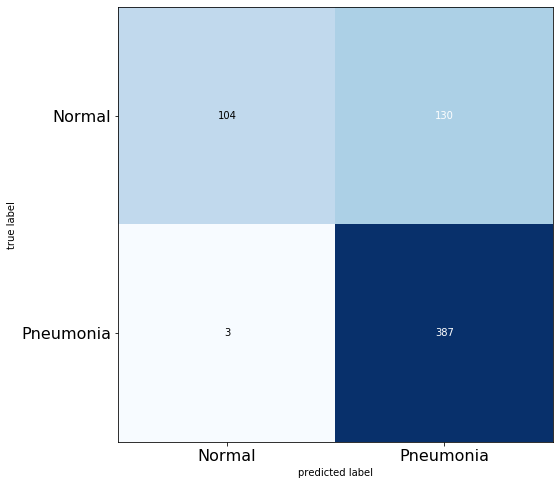

Accuracy of the model is 0.79
Recall of the model is 0.99
Precision of the model is 0.75
specificity of the model is 0.44
F1_score of the model is 0.85


In [85]:
# getting the model created from scrach
NeumoNet1 = get_model()

# getting the model created from scrach summary
NeumoNet1.summary()

# ploting the NeumoNet1 architecture
# from keras.utils import plot_model
# plot_model(NeumoNet1, to_file='pneumo.png', show_shapes=True)

# training and getting the model with out Data Augmentation created from scrach history 
model_history = train_model(NeumoNet1, train_data, train_labels, valid_data, valid_labels)  # bug to be fix next

# training and getting the model with data Augmentation created from scrach history 
model_history = train_model_Data_Aug(NeumoNet1, train_dir, validation_dir)

#visualizing the model Activation
get_intermediate_Activation(NeumoNet1, '/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')

# plotting the model accuracy
plot_Model_Accuracy(model_history)

# plotting the model loos
plot_Model_loss(model_history)

# getting the model prediction in test data
NeumoNet1_pred, orig_test_labels = get_Model_prediction(NeumoNet1, test_data, test_labels)

# printing the prediction
print(NeumoNet1_pred)

# getting the evaluation matrics 
get_Evaluation_matrics(NeumoNet1_pred, orig_test_labels)

# Evaluating the model with test data
get_model_evaluation_generator(NeumoNet1, test_dir)

# **Building model using transfer learning with VGG16**

<Figure size 432x288 with 0 Axes>

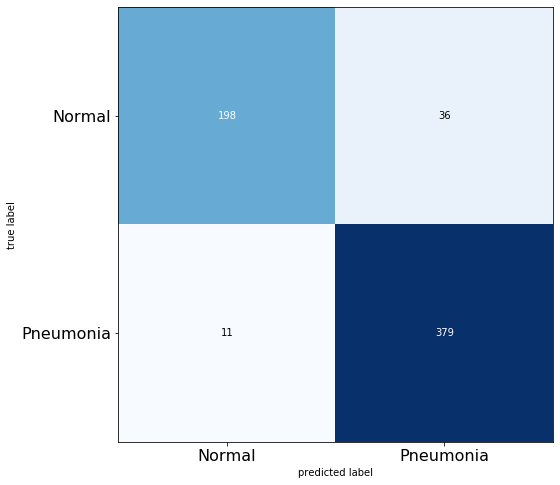

Accuracy of the model is 0.92
Recall of the model is 0.97
Precision of the model is 0.91
specificity of the model is 0.85
F1_score of the model is 0.94


In [74]:
# getting the model created from VGG16 using transfer learnig
NeumoNet2 = get_model_VGG16()

# getting the model created from VGG16 using transfer learnig summary
NeumoNet2.summary()

# ploting the NeumoNet2 architecture
from keras.utils import plot_model
plot_model(NeumoNet2, to_file='pneumo.png', show_shapes=True)

# training and getting the model with out Data Augmentation created from scrach history 
VGG_model_history0 = train_model(NeumoNet2, train_data, train_labels, valid_data, valid_labels)

# training and getting the model created from VGG16 using transfer learnig summary
VGG_model_history = train_model_Data_Aug(NeumoNet2, train_dir, validation_dir)

# plotting the model accuracy
plot_Model_Accuracy(VGG_model_history)

# plotting the model loos
plot_Model_loss(VGG_model_history)

# getting the model prediction in test data
NeumoNet2_pred, orig_test_labels = get_Model_prediction(NeumoNet2, test_data, test_labels)

# printing the prediction
print(NeumoNet2_pred)

# getting the evaluation matrics 
get_Evaluation_matrics(NeumoNet2_pred, orig_test_labels)

# Evaluating the model with test data
get_model_evaluation_generator(NeumoNet2, test_dir)
